## Load Data from GDrive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/dataset.zip"

Archive:  /content/drive/MyDrive/dataset.zip
   creating: dataset/
   creating: dataset/test/
  inflating: dataset/test/TCGA-HU-A4GY-11A-01-TS1.63A3B7C0-63D1-4A3C-8325-79A4513A81BA_aug_0.png  
  inflating: dataset/test/TCGA-D7-8572-01A-01-TS1.82bad051-98fe-4b93-bcb6-2700c45e825e_aug_2.png  
  inflating: dataset/test/TCGA-V5-AASX-01A-01-TS1.0E65F14D-AF31-47A3-9CD1-DEEF104B666A_aug_9.png  
  inflating: dataset/test/TCGA-IG-A5S3-01A-01-TSA.0F1D563E-E7BA-4960-ABE7-AE05B9B3E538_aug_9.png  
  inflating: dataset/test/TCGA-BR-6457-11A-01-TS1.392499ee-61c9-4c26-801a-cdaf95e3e258_aug_1.png  
  inflating: dataset/test/TCGA-FP-7916-01Z-00-DX1.6264d8c6-0ddb-4905-ad0c-146e380ddee1_aug_2.png  
  inflating: dataset/test/TCGA-IG-A8O2-01A-01-TSA.9EEBA012-48B5-43E5-A154-D082B21D3B75_aug_4.png  
  inflating: dataset/test/TCGA-VR-AA4D-01A-01-TS1.F684C8CF-D1A7-4BAF-B32A-98BABEBD9472_aug_5.png  
  inflating: dataset/test/TCGA-LN-A4A2-01Z-00-DX1.41B9C9F4-C350-4FDF-A894-F23DDD6D3898_aug_8.png  
  inflating: da

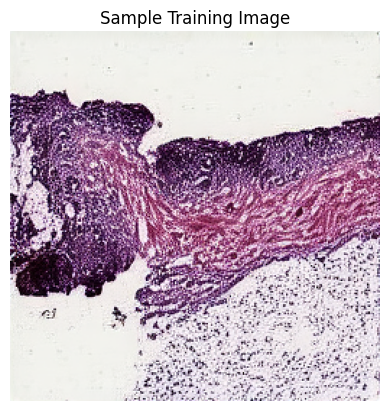

In [3]:
import cv2
import matplotlib.pyplot as plt

# Test image loading
img = cv2.imread("/content/dataset/train/TCGA-2H-A9GF-01A-01-TS1.AE2090EE-B101-4F35-90F7-9D1B37BED787_aug_0.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Sample Training Image")
plt.axis('off')
plt.show()

## Import Libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.class_weight import compute_class_weight

import timm

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


## Data Loading - PyTorch Dataset & DataLoader

In [5]:
class HistologyDataset(Dataset):
    """
    PyTorch Dataset for histology images from CSV files

    Args:
        csv_path: Path to CSV file with columns ['image_name', 'label']
        images_dir: Directory containing the images
        transform: torchvision transforms to apply
    """

    def __init__(self, csv_path, images_dir, transform=None):
        self.df = pd.read_csv(csv_path)
        self.images_dir = images_dir
        self.transform = transform

        # Create label mapping
        self.unique_labels = sorted(self.df['label'].unique())
        self.label_to_idx = {label: i for i, label in enumerate(self.unique_labels)}
        self.idx_to_label = {i: label for i, label in enumerate(self.unique_labels)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and load
        img_name = self.df.iloc[idx]['image_name']
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Get label
        label_str = self.df.iloc[idx]['label']
        label = self.label_to_idx[label_str]

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label


def create_dataloaders(base_dir, batch_size=8, num_workers=2):
    """
    Create PyTorch DataLoaders for train, validation, and test sets

    Args:
        base_dir: Base directory containing train.csv, val.csv, test.csv and image folders
        batch_size: Batch size for DataLoader
        num_workers: Number of worker processes for data loading

    Returns:
        train_loader, val_loader, test_loader, idx_to_label mapping
    """

    # Training transforms with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Validation/Test transforms (no augmentation)
    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = HistologyDataset(
        csv_path=os.path.join(base_dir, 'train.csv'),
        images_dir=os.path.join(base_dir, 'train'),
        transform=train_transform
    )

    val_dataset = HistologyDataset(
        csv_path=os.path.join(base_dir, 'val.csv'),
        images_dir=os.path.join(base_dir, 'val'),
        transform=val_test_transform
    )

    test_dataset = HistologyDataset(
        csv_path=os.path.join(base_dir, 'test.csv'),
        images_dir=os.path.join(base_dir, 'test'),
        transform=val_test_transform
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    return train_loader, val_loader, test_loader, train_dataset.idx_to_label

print("✅ PyTorch Dataset and DataLoader classes defined!")

✅ PyTorch Dataset and DataLoader classes defined!


## Model Definition

In [6]:
def build_model(model_name='vit_base_patch16_224', num_classes=3, pretrained=True):
    """
    Build a Vision Transformer model using timm library

    Args:
        model_name: Name of the model from timm
                   - 'vit_base_patch16_224' (default): ViT-Base with 16x16 patches
                   - 'vit_base_patch16_224.augreg_in21k': ViT-Base pretrained on ImageNet-21k
                   - 'vit_large_patch16_224': ViT-Large for better performance
        num_classes: Number of output classes
        pretrained: Whether to use pretrained weights

    Returns:
        PyTorch model
    """
    model = timm.create_model(
        model_name,
        pretrained=pretrained,
        num_classes=num_classes
    )
    return model

print("✅ Vision Transformer model building function defined!")

✅ Vision Transformer model building function defined!


In [7]:
def freeze_layers(model, num_layers_to_train=2):
    """
    Freeze backbone layers and only train the last few transformer blocks + head

    For ViT-Base (12 blocks):
    - num_layers_to_train=0: Only train classification head
    - num_layers_to_train=2: Train last 2 blocks + head (recommended)
    - num_layers_to_train=4: Train last 4 blocks + head
    - num_layers_to_train=12: Train all blocks (full fine-tuning)

    Args:
        model: Vision Transformer model
        num_layers_to_train: Number of transformer blocks to keep trainable

    Returns:
        model: Model with frozen layers
    """

    # First, freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Always keep the classification head trainable
    if hasattr(model, 'head'):
        for param in model.head.parameters():
            param.requires_grad = True

    # Unfreeze the last N transformer blocks
    if num_layers_to_train > 0 and hasattr(model, 'blocks'):
        total_blocks = len(model.blocks)
        blocks_to_train = min(num_layers_to_train, total_blocks)

        for i in range(total_blocks - blocks_to_train, total_blocks):
            for param in model.blocks[i].parameters():
                param.requires_grad = True

    # Count trainable parameters
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())

    print(f"🔒 Layer Freezing Applied:")
    print(f"  Total blocks: {len(model.blocks) if hasattr(model, 'blocks') else 'N/A'}")
    print(f"  Trainable blocks: {num_layers_to_train}")
    print(f"  Frozen parameters: {total - trainable:,}")
    print(f"  Trainable parameters: {trainable:,} ({100*trainable/total:.1f}%)")

    return model

print("✅ Layer freezing function defined!")

✅ Layer freezing function defined!


## Training Loop

In [8]:
def train_model(model, train_loader, val_loader, class_weights, epochs=50, lr=1e-4, device='cuda'):
    """
    Train PyTorch model with validation

    Args:
        model: PyTorch model to train
        train_loader: Training DataLoader
        val_loader: Validation DataLoader
        class_weights: Dictionary of class weights {class_idx: weight}
        epochs: Number of training epochs
        lr: Learning rate
        device: Device to train on ('cuda' or 'cpu')

    Returns:
        history: Dictionary containing training history
        model: Trained model
    """

    # Setup device
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f"🖥️  Training on: {device}")

    # Loss function with class weights
    class_weights_tensor = torch.FloatTensor(list(class_weights.values())).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.9,
        patience=3,
        min_lr=1e-6
    )

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    best_val_acc = 0.0
    patience_counter = 0
    early_stop_patience = 9

    print(f"\n🎯 Starting training for {epochs} epochs...\n")

    for epoch in range(epochs):
        # ===================== Training Phase =====================
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]', leave=False)

        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Update progress bar
            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100. * train_correct / train_total:.2f}%'
            })

        train_loss = train_loss / train_total
        train_acc = train_correct / train_total

        # ===================== Validation Phase =====================
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [Val]', leave=False)

            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100. * val_correct / val_total:.2f}%'
                })

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        # Update history
        current_lr = optimizer.param_groups[0]['lr']
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Print epoch summary
        print(f'Epoch {epoch+1}/{epochs} - '
              f'train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, '
              f'val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}, '
              f'lr: {current_lr:.2e}')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, 'best_model.pth')
            print(f'✅ Saved best model with val_acc: {val_acc:.4f}')
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= early_stop_patience:
            print(f'\n⚠️  Early stopping triggered after {epoch+1} epochs')
            break

    print(f"\n✅ Training completed!")
    print(f"📊 Best validation accuracy: {best_val_acc:.4f}")

    return history, model

print("✅ Training function defined!")

✅ Training function defined!


## Dataset Preparation

🚀 Loading datasets and analyzing...

📊 Dataset Summary:
  Training patches: 2204
  Validation patches: 472
  Test patches: 473
  Number of classes: 3
  Class names: ['Esophageal Adenocarcinoma', 'Esophageal Squamous Cell Carcinoma', 'Esophagogastric Cancer']

⚖️  Class weights (for balanced training):
  Esophageal Adenocarcinoma: 0.9835
  Esophageal Squamous Cell Carcinoma: 0.9667
  Esophagogastric Cancer: 1.0540

📐 Sample batch shape: torch.Size([8, 3, 224, 224])
🏷️  Sample labels: [1 2 2 1 2 1 0 0]


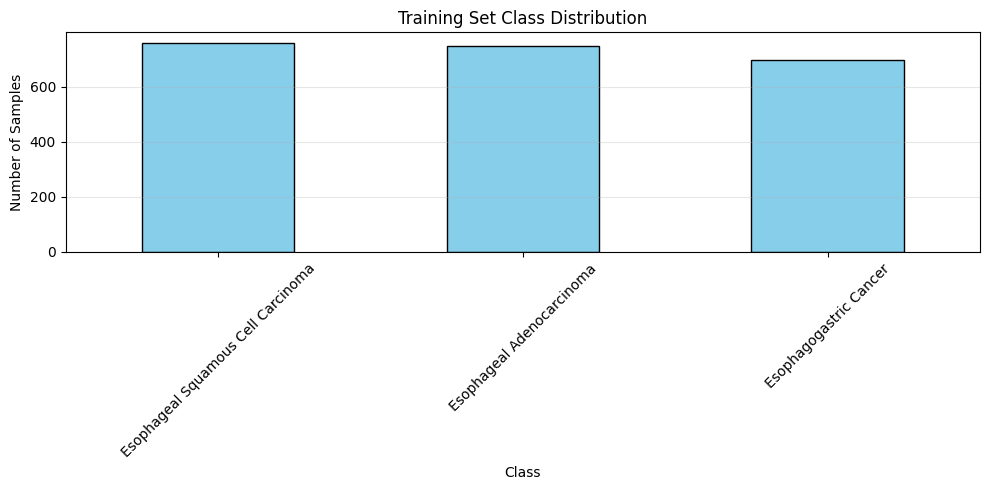

In [9]:
print("🚀 Loading datasets and analyzing...")
base_dir = "dataset"

# Create PyTorch DataLoaders
train_loader, val_loader, test_loader, idx_to_label = create_dataloaders(
    base_dir,
    batch_size=8,
    num_workers=2
)

# Get class names
class_names = [idx_to_label[i] for i in sorted(idx_to_label.keys())]
num_classes = len(class_names)

# Calculate class weights for balanced training
train_labels_df = pd.read_csv(os.path.join(base_dir, "train.csv"))
label_to_index = {label: i for i, label in enumerate(class_names)}
train_numerical_labels = np.array([label_to_index[label] for label in train_labels_df['label']])

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_numerical_labels),
    y=train_numerical_labels
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print dataset summary
print(f"\n📊 Dataset Summary:")
print(f"  Training patches: {len(train_labels_df)}")
print(f"  Validation patches: {len(pd.read_csv(os.path.join(base_dir, 'val.csv')))}")
print(f"  Test patches: {len(pd.read_csv(os.path.join(base_dir, 'test.csv')))}")
print(f"  Number of classes: {num_classes}")
print(f"  Class names: {class_names}")
print(f"\n⚖️  Class weights (for balanced training):")
for class_name, weight in zip(class_names, class_weights):
    print(f"  {class_name}: {weight:.4f}")

# Show sample batch
sample_images, sample_labels = next(iter(train_loader))
print(f"\n📐 Sample batch shape: {sample_images.shape}")
print(f"🏷️  Sample labels: {sample_labels.numpy()[:10]}")

# Visualize class distribution
plt.figure(figsize=(10, 5))
train_labels_df['label'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Build Model

In [10]:
print("🔨 Building Vision Transformer (ViT-Base) model...")
model = build_model(model_name='vit_base_patch16_224', num_classes=num_classes, pretrained=True)

# Model summary
print(f"\n📋 Model Summary:")
print(f"  Model: Vision Transformer (ViT-Base)")
print(f"  Architecture: 12 transformer layers, 768 hidden dim, 12 attention heads")
print(f"  Patch size: 16x16")
print(f"  Pretrained: ImageNet-1k weights")
print(f"  Input size: 224x224x3")
print(f"  Output classes: {num_classes}")

print(f"\n🧮 Model Parameters (Before Freezing):")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Apply layer freezing for fine-tuning
print(f"\n❄️  Applying fine-tuning strategy...")

model = freeze_layers(model, num_layers_to_train=2)
print(f"\n✅ ViT model configured for fine-tuning!")


🔨 Building Vision Transformer (ViT-Base) model...


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


📋 Model Summary:
  Model: Vision Transformer (ViT-Base)
  Architecture: 12 transformer layers, 768 hidden dim, 12 attention heads
  Patch size: 16x16
  Pretrained: ImageNet-1k weights
  Input size: 224x224x3
  Output classes: 3

🧮 Model Parameters (Before Freezing):
  Total parameters: 85,800,963
  Trainable parameters: 85,800,963

❄️  Applying fine-tuning strategy...
🔒 Layer Freezing Applied:
  Total blocks: 12
  Trainable blocks: 2
  Frozen parameters: 71,622,912
  Trainable parameters: 14,178,051 (16.5%)

✅ ViT model configured for fine-tuning!


## Train Model

In [11]:
print("🎯 Starting model training...")
print("Configuration:")
print(f"  Training strategy: Fine-tuning (last 2 blocks + head)")
print(f"  Epochs: 50")
print(f"  Learning rate: 1e-4")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: ReduceLROnPlateau")
print(f"  Early stopping patience: 9 epochs")
print()

history, trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    class_weights=class_weight_dict,
    epochs=50,
    lr=1e-4,
    device='cuda'
)

print("\n🎉 Training completed successfully!")

🎯 Starting model training...
Configuration:
  Training strategy: Fine-tuning (last 2 blocks + head)
  Epochs: 50
  Learning rate: 1e-4
  Optimizer: AdamW
  Scheduler: ReduceLROnPlateau
  Early stopping patience: 9 epochs

🖥️  Training on: cuda

🎯 Starting training for 50 epochs...



Epoch 1/50 [Train]:  88%|████████▊ | 243/276 [01:12<00:10,  3.18it/s, loss=0.6254, acc=58.38%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/50 - train_loss: 0.9145, train_acc: 0.5903, val_loss: 0.7282, val_acc: 0.6970, lr: 1.00e-04
✅ Saved best model with val_acc: 0.6970


Epoch 2/50 [Train]:   7%|▋         | 18/276 [00:07<01:09,  3.70it/s, loss=0.6612, acc=75.00%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2/50 - train_loss: 0.6423, train_acc: 0.7382, val_loss: 0.5428, val_acc: 0.7797, lr: 1.00e-04
✅ Saved best model with val_acc: 0.7797


Epoch 3/50 [Train]:  94%|█████████▍| 260/276 [01:17<00:02,  6.01it/s, loss=0.0919, acc=81.30%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3/50 - train_loss: 0.4781, train_acc: 0.8149, val_loss: 0.5816, val_acc: 0.7712, lr: 1.00e-04


Epoch 4/50 [Train]:  84%|████████▎ | 231/276 [01:09<00:11,  3.82it/s, loss=0.2751, acc=85.98%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4/50 - train_loss: 0.3817, train_acc: 0.8548, val_loss: 0.5343, val_acc: 0.7860, lr: 1.00e-04
✅ Saved best model with val_acc: 0.7860


Epoch 5/50 [Train]:  56%|█████▌    | 155/276 [00:46<00:57,  2.09it/s, loss=0.0567, acc=89.19%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5/50 - train_loss: 0.2949, train_acc: 0.8920, val_loss: 0.7159, val_acc: 0.7648, lr: 1.00e-04


Epoch 6/50 [Train]:  65%|██████▍   | 179/276 [00:53<00:36,  2.63it/s, loss=0.7174, acc=90.15%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6/50 - train_loss: 0.2612, train_acc: 0.9079, val_loss: 0.4332, val_acc: 0.8305, lr: 1.00e-04
✅ Saved best model with val_acc: 0.8305


Epoch 7/50 [Train]:  39%|███▉      | 109/276 [00:32<00:29,  5.59it/s, loss=0.1896, acc=92.43%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7/50 - train_loss: 0.1931, train_acc: 0.9256, val_loss: 0.3926, val_acc: 0.8581, lr: 1.00e-04
✅ Saved best model with val_acc: 0.8581


Epoch 8/50 [Train]:  93%|█████████▎| 256/276 [01:16<00:06,  3.33it/s, loss=0.0986, acc=93.99%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8/50 - train_loss: 0.1681, train_acc: 0.9397, val_loss: 0.3579, val_acc: 0.8771, lr: 1.00e-04
✅ Saved best model with val_acc: 0.8771


Epoch 9/50 [Train]:   0%|          | 1/276 [00:00<01:28,  3.11it/s, loss=0.0859, acc=100.00%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9/50 - train_loss: 0.1252, train_acc: 0.9551, val_loss: 0.4591, val_acc: 0.8432, lr: 1.00e-04


Epoch 10/50 [Train]:  48%|████▊     | 132/276 [00:38<00:26,  5.40it/s, loss=0.0342, acc=94.13%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10/50 - train_loss: 0.1528, train_acc: 0.9446, val_loss: 0.3481, val_acc: 0.8814, lr: 1.00e-04
✅ Saved best model with val_acc: 0.8814


Epoch 11/50 [Train]:  22%|██▏       | 62/276 [00:22<00:53,  3.96it/s, loss=0.5605, acc=95.77%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11/50 - train_loss: 0.1136, train_acc: 0.9574, val_loss: 0.3192, val_acc: 0.8814, lr: 1.00e-04


Epoch 12/50 [Train]:  84%|████████▍ | 232/276 [01:09<00:14,  3.11it/s, loss=0.1476, acc=96.55%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12/50 - train_loss: 0.1088, train_acc: 0.9605, val_loss: 0.4283, val_acc: 0.8602, lr: 1.00e-04


Epoch 13/50 [Train]:  39%|███▉      | 109/276 [00:31<00:27,  6.16it/s, loss=0.8107, acc=97.13%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13/50 - train_loss: 0.0867, train_acc: 0.9673, val_loss: 0.4182, val_acc: 0.8856, lr: 1.00e-04
✅ Saved best model with val_acc: 0.8856


Epoch 14/50 [Train]:  75%|███████▍  | 206/276 [01:04<00:26,  2.60it/s, loss=0.0126, acc=97.09%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14/50 - train_loss: 0.0875, train_acc: 0.9719, val_loss: 0.4707, val_acc: 0.8771, lr: 1.00e-04


Epoch 15/50 [Train]:   8%|▊         | 22/276 [00:06<01:01,  4.14it/s, loss=0.0002, acc=98.86%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15/50 - train_loss: 0.0801, train_acc: 0.9728, val_loss: 0.3725, val_acc: 0.9047, lr: 1.00e-04
✅ Saved best model with val_acc: 0.9047


Epoch 16/50 [Train]:  23%|██▎       | 63/276 [00:19<00:57,  3.69it/s, loss=0.3455, acc=98.41%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16/50 - train_loss: 0.0674, train_acc: 0.9782, val_loss: 0.4408, val_acc: 0.8792, lr: 9.00e-05


Epoch 17/50 [Train]:  54%|█████▍    | 149/276 [00:44<00:33,  3.74it/s, loss=0.0229, acc=97.99%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17/50 - train_loss: 0.0629, train_acc: 0.9800, val_loss: 0.4120, val_acc: 0.8941, lr: 9.00e-05


Epoch 18/50 [Train]:  15%|█▍        | 41/276 [00:12<01:04,  3.63it/s, loss=0.0005, acc=99.39%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18/50 - train_loss: 0.0690, train_acc: 0.9755, val_loss: 0.3311, val_acc: 0.9047, lr: 9.00e-05


Epoch 19/50 [Train]:  62%|██████▏   | 172/276 [00:51<00:16,  6.30it/s, loss=0.0038, acc=97.46%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19/50 - train_loss: 0.0612, train_acc: 0.9805, val_loss: 0.5309, val_acc: 0.8686, lr: 9.00e-05


Epoch 20/50 [Train]:  52%|█████▏    | 144/276 [00:43<00:30,  4.32it/s, loss=0.0053, acc=97.40%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20/50 - train_loss: 0.0688, train_acc: 0.9764, val_loss: 0.3547, val_acc: 0.8877, lr: 8.10e-05


Epoch 21/50 [Train]:  68%|██████▊   | 189/276 [00:55<00:31,  2.80it/s, loss=0.0032, acc=98.68%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21/50 - train_loss: 0.0445, train_acc: 0.9850, val_loss: 0.4806, val_acc: 0.8623, lr: 8.10e-05


Epoch 22/50 [Train]:  25%|██▌       | 70/276 [00:21<00:57,  3.57it/s, loss=0.0003, acc=99.46%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22/50 - train_loss: 0.0435, train_acc: 0.9873, val_loss: 0.5099, val_acc: 0.8771, lr: 8.10e-05


Epoch 23/50 [Train]:  20%|█▉        | 54/276 [00:15<01:28,  2.51it/s, loss=0.0022, acc=98.38%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23/50 - train_loss: 0.0470, train_acc: 0.9828, val_loss: 0.4888, val_acc: 0.8665, lr: 8.10e-05


Epoch 24/50 [Train]:  32%|███▏      | 88/276 [00:30<01:26,  2.17it/s, loss=0.0002, acc=99.01%]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (92165542 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
                                                                                           

Epoch 24/50 - train_loss: 0.0397, train_acc: 0.9859, val_loss: 0.4691, val_acc: 0.8771, lr: 7.29e-05

⚠️  Early stopping triggered after 24 epochs

✅ Training completed!
📊 Best validation accuracy: 0.9047

🎉 Training completed successfully!


## Visualization - Training History

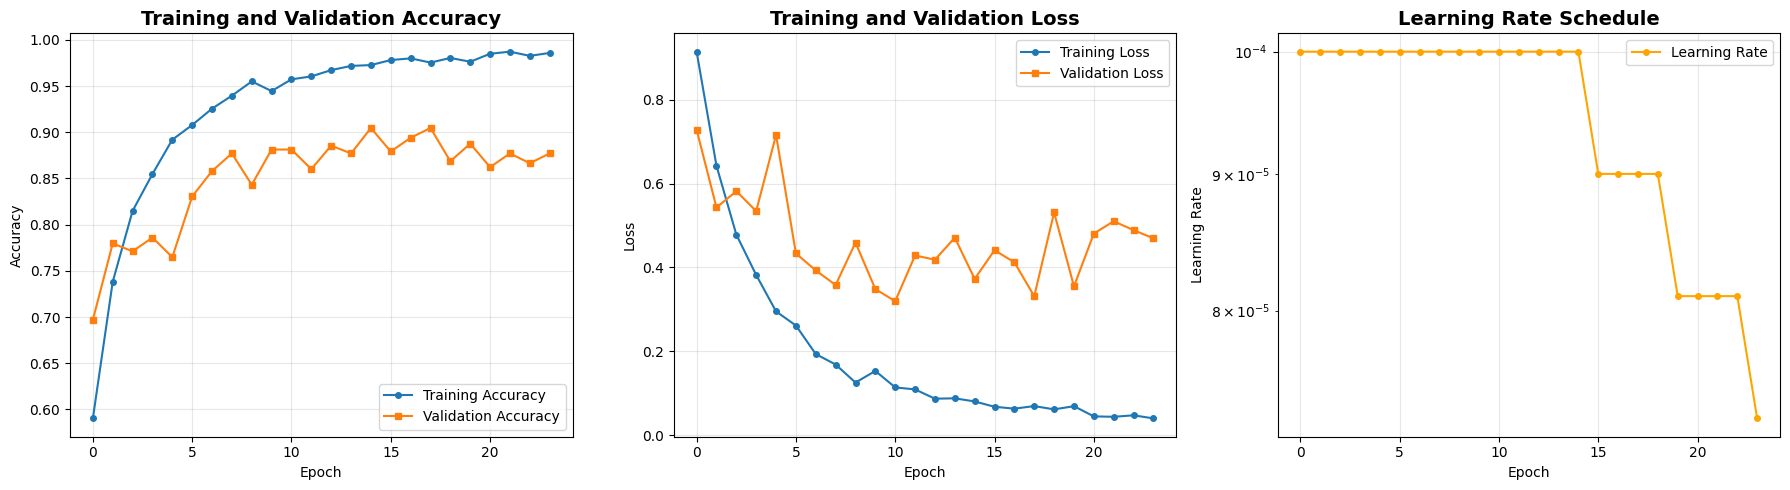


📊 Final Training Metrics:
  Final train accuracy: 0.9859
  Final val accuracy: 0.8771
  Best val accuracy: 0.9047 (epoch 15)
  Final train loss: 0.0397
  Final val loss: 0.4691


In [12]:
def plot_training_history(history):
    """Plot training history with loss and accuracy curves"""

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Accuracy
    axes[0].plot(history['train_acc'], label='Training Accuracy', marker='o', markersize=4)
    axes[0].plot(history['val_acc'], label='Validation Accuracy', marker='s', markersize=4)
    axes[0].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Loss
    axes[1].plot(history['train_loss'], label='Training Loss', marker='o', markersize=4)
    axes[1].plot(history['val_loss'], label='Validation Loss', marker='s', markersize=4)
    axes[1].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Plot 3: Learning Rate
    axes[2].plot(history['lr'], label='Learning Rate', marker='o', markersize=4, color='orange')
    axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_yscale('log')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print(f"\n📊 Final Training Metrics:")
    print(f"  Final train accuracy: {history['train_acc'][-1]:.4f}")
    print(f"  Final val accuracy: {history['val_acc'][-1]:.4f}")
    print(f"  Best val accuracy: {max(history['val_acc']):.4f} (epoch {np.argmax(history['val_acc'])+1})")
    print(f"  Final train loss: {history['train_loss'][-1]:.4f}")
    print(f"  Final val loss: {history['val_loss'][-1]:.4f}")

# Plot training history
plot_training_history(history)

## Load Best Model

In [13]:
# Load best model checkpoint
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("✅ Loaded best model weights")
print(f"📊 Best model performance:")
print(f"  Epoch: {checkpoint['epoch']+1}")
print(f"  Validation accuracy: {checkpoint['val_acc']:.4f}")
print(f"  Validation loss: {checkpoint['val_loss']:.4f}")

✅ Loaded best model weights
📊 Best model performance:
  Epoch: 15
  Validation accuracy: 0.9047
  Validation loss: 0.3725


## Model Evaluation


📈 EVALUATING MODEL ON TEST SET:


Evaluating: 100%|██████████| 60/60 [00:17<00:00,  3.50it/s]



✅ Test Results:
  Test Accuracy: 0.8816 (88.16%)
  Test Loss: 0.5181

📊 Detailed Classification Report:
                                    precision    recall  f1-score   support

         Esophageal Adenocarcinoma     0.8521    0.9351    0.8916       154
Esophageal Squamous Cell Carcinoma     0.8935    0.9321    0.9124       162
            Esophagogastric Cancer     0.9037    0.7771    0.8356       157

                          accuracy                         0.8816       473
                         macro avg     0.8831    0.8814    0.8799       473
                      weighted avg     0.8834    0.8816    0.8802       473



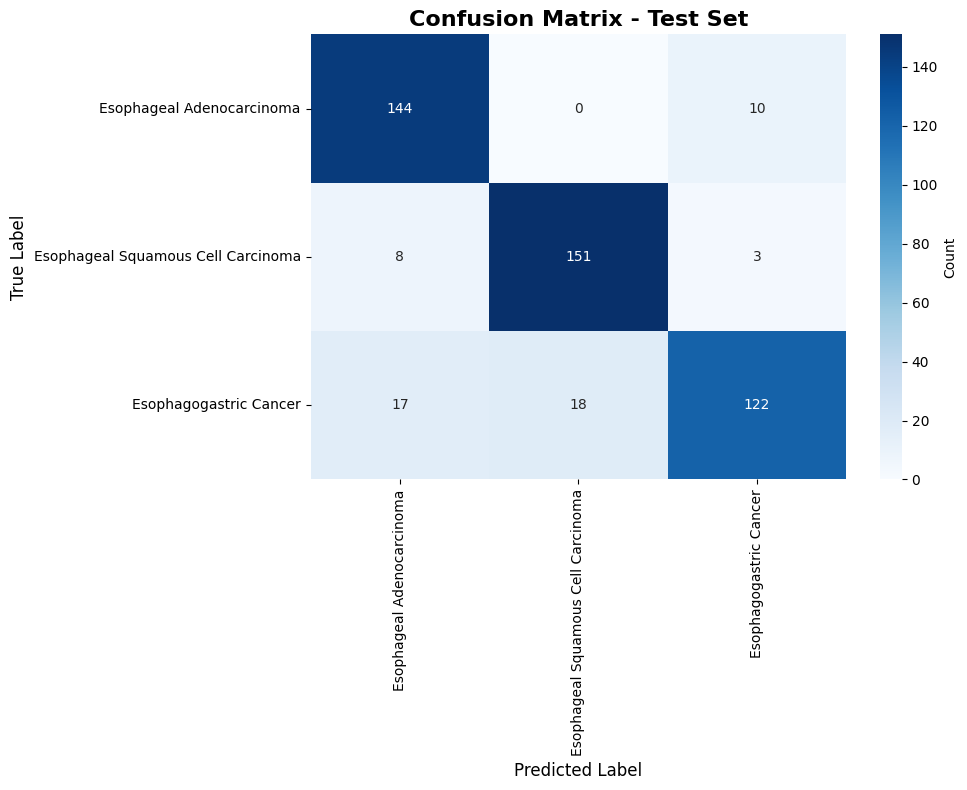


📊 Per-Class Accuracy:
  Esophageal Adenocarcinoma: 0.9351 (93.51%) - 154 samples
  Esophageal Squamous Cell Carcinoma: 0.9321 (93.21%) - 162 samples
  Esophagogastric Cancer: 0.7771 (77.71%) - 157 samples


In [14]:
def evaluate_model(model, test_loader, class_names, device='cuda'):
    """
    Evaluate model on test set and generate comprehensive metrics

    Args:
        model: PyTorch model to evaluate
        test_loader: Test DataLoader
        class_names: List of class names
        device: Device to run evaluation on

    Returns:
        Dictionary with evaluation metrics
    """
    print("\n📈 EVALUATING MODEL ON TEST SET:")
    print("=" * 50)

    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    y_true = []
    y_pred = []
    y_pred_proba = []
    test_loss = 0.0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Get predictions
            proba = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            # Collect results
            test_loss += loss.item() * images.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_pred_proba.extend(proba.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = np.mean(np.array(y_true) == np.array(y_pred))

    print(f"\n✅ Test Results:")
    print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"  Test Loss: {test_loss:.4f}")

    # Classification report
    print(f"\n📊 Detailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Per-class accuracy
    print(f"\n📊 Per-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_mask = np.array(y_true) == i
        class_acc = np.mean(np.array(y_pred)[class_mask] == i)
        class_count = np.sum(class_mask)
        print(f"  {class_name}: {class_acc:.4f} ({class_acc*100:.2f}%) - {class_count} samples")

    return {
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'confusion_matrix': cm
    }

# Evaluate model
eval_results = evaluate_model(model, test_loader, class_names, device='cuda')

## ROC Curves and AUC Scores

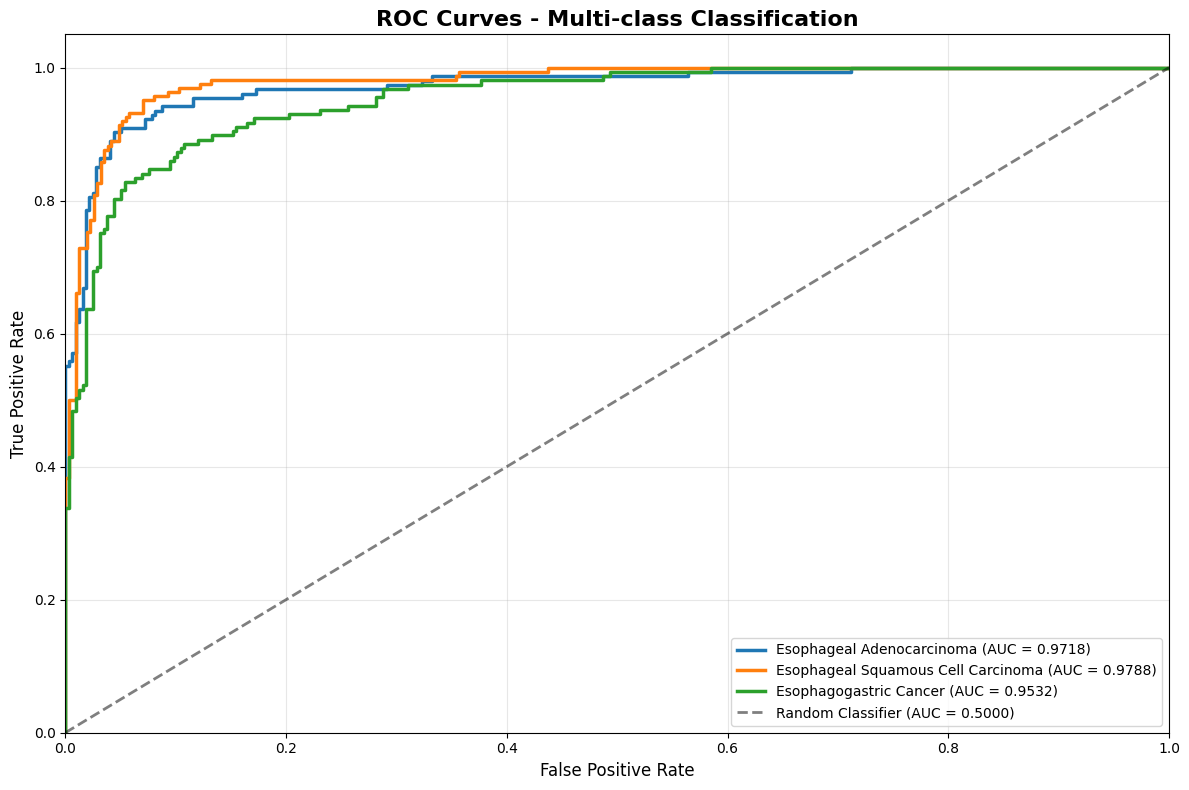


📊 AUC Scores Summary:
  Esophageal Adenocarcinoma: 0.9718
  Esophageal Squamous Cell Carcinoma: 0.9788
  Esophagogastric Cancer: 0.9532
  Mean AUC       : 0.9679


In [15]:
def plot_roc_curves(y_true, y_pred_proba, class_names):
    """
    Plot ROC curves for multi-class classification

    Args:
        y_true: True labels
        y_pred_proba: Predicted probabilities
        class_names: List of class names
    """

    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)

    # Binarize labels for multi-class ROC
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    plt.figure(figsize=(12, 8))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

    for i, class_name in enumerate(class_names):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i],
                label=f'{class_name} (AUC = {roc_auc[i]:.4f})',
                linewidth=2.5,
                color=colors[i % len(colors)])

    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=2, label='Random Classifier (AUC = 0.5000)')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Multi-class Classification', fontsize=16, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print AUC scores summary
    print("\n📊 AUC Scores Summary:")
    print("=" * 40)
    for i, class_name in enumerate(class_names):
        print(f"  {class_name:15s}: {roc_auc[i]:.4f}")
    print(f"  {'Mean AUC':15s}: {np.mean(list(roc_auc.values())):.4f}")

    return fpr, tpr, roc_auc

# Plot ROC curves
fpr, tpr, roc_auc = plot_roc_curves(
    eval_results['y_true'],
    eval_results['y_pred_proba'],
    class_names
)